In [34]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.metrics import root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("./correlation-data/r22-24_processed.csv")
df["LapTime"] = df["LapTime"] - df["racemean"]
df = df.drop(columns=["racemean"])
df_dry = df[df["Rainfall"] == 0.0]
df_dry = df_dry.drop(columns=["Rainfall"])
X_dry = df_dry.drop(columns=['LapTime'])
y_dry = df_dry['LapTime']
df_wet = df[df["Rainfall"] == 1.0]
df_wet = df_wet.drop(columns=["Rainfall"])
X_wet = df_wet.drop(columns=['LapTime'])
y_wet = df_wet['LapTime']
df = df.drop(columns=["Rainfall"])

X = df.drop(columns=['LapTime'])
y = df['LapTime']

categorical_feats = ['Compound', "Rainfall"]
categorical_feats = [c for c in X.columns if c.startswith(tuple(categorical_feats))]
numerical_features = [c for c in X.columns if not c.startswith(tuple(categorical_feats))]

#Remove Compound_INTERMEDIATE and Compound_WET from dry dataset
X_dry = X_dry.drop(columns=["Compound_INTERMEDIATE", "Compound_WET"])

X_dry_train, X_dry_test, y_dry_train, y_dry_test = train_test_split(X_dry, y_dry, test_size=0.2, random_state=3465475)
X_wet_train, X_wet_test, y_wet_train, y_wet_test = train_test_split(X_wet, y_wet, test_size=0.2, random_state=2351246)

In [13]:
def make_pipeline(n_est,max_depth,random_state,num_leaves,learning_rate,min_data_in_leaf):
    preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), numerical_features),
    ],remainder='passthrough')

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("lgbm", lgb.LGBMRegressor(
            n_estimators=n_est,
            random_state=random_state,
            num_leaves=num_leaves,
            max_depth=max_depth,
            metric='rmse',
            learning_rate=learning_rate,
            min_data_in_leaf=min_data_in_leaf,
        ))
    ])
    return pipeline


In [4]:
import optuna

def run_cv(trial: optuna.Trial, X_train, y_train):
    preprocessor = ColumnTransformer(transformers=[
        ("scaler", StandardScaler(), numerical_features),
    ],remainder='passthrough')

    max_depth = trial.suggest_int('max_depth', 3, 15, step=2)
    num_leaves = trial.suggest_int('num_leaves', 2**(max_depth-2), 2**max_depth, step=2**(max_depth-3))
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 10, 500, step=20),
    lr = trial.suggest_float('learning_rate', 0.001, 0.1)

    model = lgb.LGBMRegressor(
        n_estimators=10000,
        num_leaves=num_leaves,
        min_data_in_leaf=min_data_in_leaf,
        learning_rate=lr,
        max_depth=max_depth,
        random_state=7643,
        n_jobs=-1,
        verbose=-1
    )
    kfold = KFold(n_splits=10, shuffle=True, random_state=346436)
    scores = []
    best_iters = []
    for train_ind, val_ind in kfold.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_ind], X_train.iloc[val_ind]
        y_train_fold, y_val_fold = y_train.iloc[train_ind], y_train.iloc[val_ind]
        X_train_fold = preprocessor.fit_transform(X_train_fold)
        X_val_fold = preprocessor.transform(X_val_fold)

        model.fit(X_train_fold, y_train_fold, eval_metric="root_mean_squared_error", feature_name=X_train.columns.to_list(),
                   eval_set=[(X_val_fold, y_val_fold)], callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)])
        scores.append(model.best_score_['valid_0']['rmse'])
        best_iters.append(model.best_iteration_)
    scores = np.array(scores)
    best_iters = np.array(best_iters)
    print(f"Trial {trial.number} - RMSE: {scores.mean():.4f}, Best Iteration: {best_iters.mean():.0f}")
    return scores.mean()


def optimize_wet(trial: optuna.Trial):
    return run_cv(trial, X_wet_train, y_wet_train)
study = optuna.create_study(direction="minimize")
study.optimize(optimize_wet, n_trials=20)
print("Best score wet:", study.best_value)
print("Best hyperparameters wet:", study.best_params)

def optimize_dry(trial: optuna.Trial):
    return run_cv(trial, X_dry_train, y_dry_train)
study_dry = optuna.create_study(direction="minimize")
study_dry.optimize(optimize_dry, n_trials=20)
print("Best score dry:", study_dry.best_value)
print("Best hyperparameters dry:", study_dry.best_params)

[I 2025-06-03 11:28:09,415] A new study created in memory with name: no-name-73033086-6729-4b67-96d6-8f2485b00a0c
C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 11:28:48,100] Trial 0 finished with value: 1.8201784461164743 and parameters: {'max_depth': 7, 'num_leaves': 112, 'min_data_in_leaf': 170, 'learning_rate': 0.013300156148264713}. Best is trial 0 with value: 1.8201784461164743.


Trial 0 - RMSE: 1.8202, Best Iteration: 5259


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 11:30:45,430] Trial 1 finished with value: 1.8032267251468017 and parameters: {'max_depth': 15, 'num_leaves': 12288, 'min_data_in_leaf': 170, 'learning_rate': 0.015973895176814235}. Best is trial 1 with value: 1.8032267251468017.


Trial 1 - RMSE: 1.8032, Best Iteration: 4674


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 11:31:25,198] Trial 2 finished with value: 1.8440184123835024 and parameters: {'max_depth': 5, 'num_leaves': 20, 'min_data_in_leaf': 210, 'learning_rate': 0.010480482817782258}. Best is trial 1 with value: 1.8032267251468017.


Trial 2 - RMSE: 1.8440, Best Iteration: 8226


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 11:32:01,881] Trial 3 finished with value: 1.8662368364628783 and parameters: {'max_depth': 11, 'num_leaves': 2048, 'min_data_in_leaf': 50, 'learning_rate': 0.014151336092801711}. Best is trial 1 with value: 1.8032267251468017.


Trial 3 - RMSE: 1.8662, Best Iteration: 2038


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 11:32:28,389] Trial 4 finished with value: 1.7887157157231144 and parameters: {'max_depth': 9, 'num_leaves': 320, 'min_data_in_leaf': 210, 'learning_rate': 0.03505676375592946}. Best is trial 4 with value: 1.7887157157231144.


Trial 4 - RMSE: 1.7887, Best Iteration: 3212


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 11:32:38,777] Trial 5 finished with value: 1.849901200414576 and parameters: {'max_depth': 9, 'num_leaves': 192, 'min_data_in_leaf': 10, 'learning_rate': 0.028180527841924236}. Best is trial 4 with value: 1.7887157157231144.


Trial 5 - RMSE: 1.8499, Best Iteration: 483


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 11:34:59,263] Trial 6 finished with value: 2.0054612245026 and parameters: {'max_depth': 3, 'num_leaves': 3, 'min_data_in_leaf': 30, 'learning_rate': 0.02922177056465045}. Best is trial 4 with value: 1.7887157157231144.


Trial 6 - RMSE: 2.0055, Best Iteration: 8738


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 11:35:13,783] Trial 7 finished with value: 1.7618045154583677 and parameters: {'max_depth': 7, 'num_leaves': 32, 'min_data_in_leaf': 270, 'learning_rate': 0.0692644203781099}. Best is trial 7 with value: 1.7618045154583677.


Trial 7 - RMSE: 1.7618, Best Iteration: 2380


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 11:35:36,901] Trial 8 finished with value: 1.773044899835846 and parameters: {'max_depth': 11, 'num_leaves': 2048, 'min_data_in_leaf': 250, 'learning_rate': 0.08053774011180392}. Best is trial 7 with value: 1.7618045154583677.


Trial 8 - RMSE: 1.7730, Best Iteration: 1685


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 11:38:07,208] Trial 9 finished with value: 1.7754453227829115 and parameters: {'max_depth': 15, 'num_leaves': 24576, 'min_data_in_leaf': 270, 'learning_rate': 0.029586135382104892}. Best is trial 7 with value: 1.7618045154583677.


Trial 9 - RMSE: 1.7754, Best Iteration: 4147


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 11:38:27,790] Trial 10 finished with value: 1.7889765726180804 and parameters: {'max_depth': 3, 'num_leaves': 7, 'min_data_in_leaf': 430, 'learning_rate': 0.07531789998780805}. Best is trial 7 with value: 1.7618045154583677.


Trial 10 - RMSE: 1.7890, Best Iteration: 5839


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 11:38:52,792] Trial 11 finished with value: 1.7320258065479721 and parameters: {'max_depth': 11, 'num_leaves': 1280, 'min_data_in_leaf': 350, 'learning_rate': 0.08263320287342613}. Best is trial 11 with value: 1.7320258065479721.


Trial 11 - RMSE: 1.7320, Best Iteration: 2483


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 11:39:59,883] Trial 12 finished with value: 1.7389539668173275 and parameters: {'max_depth': 11, 'num_leaves': 768, 'min_data_in_leaf': 370, 'learning_rate': 0.09979366656762854}. Best is trial 11 with value: 1.7320258065479721.


Trial 12 - RMSE: 1.7390, Best Iteration: 2006


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 11:42:59,122] Trial 13 finished with value: 1.7302955536075633 and parameters: {'max_depth': 13, 'num_leaves': 3072, 'min_data_in_leaf': 410, 'learning_rate': 0.09810077419106313}. Best is trial 13 with value: 1.7302955536075633.


Trial 13 - RMSE: 1.7303, Best Iteration: 2613


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 11:43:35,873] Trial 14 finished with value: 1.7245958645448376 and parameters: {'max_depth': 13, 'num_leaves': 4096, 'min_data_in_leaf': 470, 'learning_rate': 0.09723997072349967}. Best is trial 14 with value: 1.7245958645448376.


Trial 14 - RMSE: 1.7246, Best Iteration: 2732


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 11:44:11,745] Trial 15 finished with value: 1.724283279390455 and parameters: {'max_depth': 13, 'num_leaves': 4096, 'min_data_in_leaf': 490, 'learning_rate': 0.09535783178069156}. Best is trial 15 with value: 1.724283279390455.


Trial 15 - RMSE: 1.7243, Best Iteration: 2848


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 11:45:17,646] Trial 16 finished with value: 1.7270923800156979 and parameters: {'max_depth': 13, 'num_leaves': 5120, 'min_data_in_leaf': 490, 'learning_rate': 0.05127359510620017}. Best is trial 15 with value: 1.724283279390455.


Trial 16 - RMSE: 1.7271, Best Iteration: 4947


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 11:46:11,859] Trial 17 finished with value: 1.7244884174089918 and parameters: {'max_depth': 13, 'num_leaves': 5120, 'min_data_in_leaf': 470, 'learning_rate': 0.06420219830540062}. Best is trial 15 with value: 1.724283279390455.


Trial 17 - RMSE: 1.7245, Best Iteration: 4192


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 11:47:17,880] Trial 18 finished with value: 1.748285897556124 and parameters: {'max_depth': 15, 'num_leaves': 12288, 'min_data_in_leaf': 330, 'learning_rate': 0.05956339785470319}. Best is trial 15 with value: 1.724283279390455.


Trial 18 - RMSE: 1.7483, Best Iteration: 3010


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 11:48:22,846] Trial 19 finished with value: 1.7282015730328903 and parameters: {'max_depth': 13, 'num_leaves': 6144, 'min_data_in_leaf': 430, 'learning_rate': 0.05859483511724545}. Best is trial 15 with value: 1.724283279390455.
[I 2025-06-03 11:48:22,863] A new study created in memory with name: no-name-324d5456-7473-446f-ad37-e128f29e7f09


Trial 19 - RMSE: 1.7282, Best Iteration: 3914
Best score wet: 1.724283279390455
Best hyperparameters wet: {'max_depth': 13, 'num_leaves': 4096, 'min_data_in_leaf': 490, 'learning_rate': 0.09535783178069156}


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 11:49:03,721] Trial 0 finished with value: 0.8935995052623762 and parameters: {'max_depth': 13, 'num_leaves': 7168, 'min_data_in_leaf': 10, 'learning_rate': 0.0901057730630073}. Best is trial 0 with value: 0.8935995052623762.


Trial 0 - RMSE: 0.8936, Best Iteration: 123


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 11:51:19,960] Trial 1 finished with value: 0.9291668403772754 and parameters: {'max_depth': 15, 'num_leaves': 8192, 'min_data_in_leaf': 190, 'learning_rate': 0.060320554906258844}. Best is trial 0 with value: 0.8935995052623762.


Trial 1 - RMSE: 0.9292, Best Iteration: 3087


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 11:57:04,437] Trial 2 finished with value: 0.9115315685058075 and parameters: {'max_depth': 15, 'num_leaves': 28672, 'min_data_in_leaf': 490, 'learning_rate': 0.06478821458334093}. Best is trial 0 with value: 0.8935995052623762.


Trial 2 - RMSE: 0.9115, Best Iteration: 4272


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 12:08:10,888] Trial 3 finished with value: 0.9111524034771252 and parameters: {'max_depth': 15, 'num_leaves': 28672, 'min_data_in_leaf': 470, 'learning_rate': 0.03753790885006814}. Best is trial 0 with value: 0.8935995052623762.


Trial 3 - RMSE: 0.9112, Best Iteration: 7169


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 12:08:46,881] Trial 4 finished with value: 0.9163110270599317 and parameters: {'max_depth': 11, 'num_leaves': 1792, 'min_data_in_leaf': 50, 'learning_rate': 0.08569571461816286}. Best is trial 0 with value: 0.8935995052623762.


Trial 4 - RMSE: 0.9163, Best Iteration: 541


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 12:10:08,417] Trial 5 finished with value: 0.9093904740016322 and parameters: {'max_depth': 7, 'num_leaves': 112, 'min_data_in_leaf': 350, 'learning_rate': 0.06701625154112492}. Best is trial 0 with value: 0.8935995052623762.


Trial 5 - RMSE: 0.9094, Best Iteration: 6437


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 12:11:33,541] Trial 6 finished with value: 0.9114882167565137 and parameters: {'max_depth': 5, 'num_leaves': 24, 'min_data_in_leaf': 170, 'learning_rate': 0.02437723779161646}. Best is trial 0 with value: 0.8935995052623762.


Trial 6 - RMSE: 0.9115, Best Iteration: 9275


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 12:11:57,898] Trial 7 finished with value: 0.8920423740699436 and parameters: {'max_depth': 9, 'num_leaves': 256, 'min_data_in_leaf': 30, 'learning_rate': 0.06662450903474555}. Best is trial 7 with value: 0.8920423740699436.


Trial 7 - RMSE: 0.8920, Best Iteration: 644


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 12:13:25,505] Trial 8 finished with value: 0.9064231459640736 and parameters: {'max_depth': 9, 'num_leaves': 256, 'min_data_in_leaf': 170, 'learning_rate': 0.049476369382764465}. Best is trial 7 with value: 0.8920423740699436.


Trial 8 - RMSE: 0.9064, Best Iteration: 3907


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 12:14:58,080] Trial 9 finished with value: 0.9729952457334633 and parameters: {'max_depth': 5, 'num_leaves': 20, 'min_data_in_leaf': 370, 'learning_rate': 0.02861739066223846}. Best is trial 7 with value: 0.8920423740699436.


Trial 9 - RMSE: 0.9730, Best Iteration: 9842


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 12:15:43,604] Trial 10 finished with value: 1.3842218677222058 and parameters: {'max_depth': 3, 'num_leaves': 2, 'min_data_in_leaf': 90, 'learning_rate': 0.0019678517721544234}. Best is trial 7 with value: 0.8920423740699436.


Trial 10 - RMSE: 1.3842, Best Iteration: 10000


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 12:16:06,639] Trial 11 finished with value: 0.8934687438559449 and parameters: {'max_depth': 11, 'num_leaves': 1024, 'min_data_in_leaf': 10, 'learning_rate': 0.09949238731694496}. Best is trial 7 with value: 0.8920423740699436.


Trial 11 - RMSE: 0.8935, Best Iteration: 159


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 12:16:39,115] Trial 12 finished with value: 0.899597996331041 and parameters: {'max_depth': 11, 'num_leaves': 768, 'min_data_in_leaf': 110, 'learning_rate': 0.09819930678418134}. Best is trial 7 with value: 0.8920423740699436.


Trial 12 - RMSE: 0.8996, Best Iteration: 1226


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 12:16:57,616] Trial 13 finished with value: 0.8999126510080021 and parameters: {'max_depth': 9, 'num_leaves': 320, 'min_data_in_leaf': 10, 'learning_rate': 0.07830456680858311}. Best is trial 7 with value: 0.8920423740699436.


Trial 13 - RMSE: 0.8999, Best Iteration: 324


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 12:18:27,432] Trial 14 finished with value: 0.9145599522957137 and parameters: {'max_depth': 11, 'num_leaves': 1024, 'min_data_in_leaf': 250, 'learning_rate': 0.07431192936126693}. Best is trial 7 with value: 0.8920423740699436.


Trial 14 - RMSE: 0.9146, Best Iteration: 4004


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 12:18:50,907] Trial 15 finished with value: 0.8970158924485719 and parameters: {'max_depth': 7, 'num_leaves': 112, 'min_data_in_leaf': 90, 'learning_rate': 0.09918824009461795}. Best is trial 7 with value: 0.8920423740699436.


Trial 15 - RMSE: 0.8970, Best Iteration: 1548


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 12:21:37,802] Trial 16 finished with value: 0.914702750468454 and parameters: {'max_depth': 13, 'num_leaves': 3072, 'min_data_in_leaf': 270, 'learning_rate': 0.04722819865652359}. Best is trial 7 with value: 0.8920423740699436.


Trial 16 - RMSE: 0.9147, Best Iteration: 5460


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 12:21:54,334] Trial 17 finished with value: 0.90073561084143 and parameters: {'max_depth': 7, 'num_leaves': 112, 'min_data_in_leaf': 10, 'learning_rate': 0.08313037765981035}. Best is trial 7 with value: 0.8920423740699436.


Trial 17 - RMSE: 0.9007, Best Iteration: 640


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 12:25:00,009] Trial 18 finished with value: 0.9972130858546444 and parameters: {'max_depth': 9, 'num_leaves': 256, 'min_data_in_leaf': 130, 'learning_rate': 0.0037735051711993636}. Best is trial 7 with value: 0.8920423740699436.


Trial 18 - RMSE: 0.9972, Best Iteration: 9832


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [10, 500] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 490].
  warnings.warn(
[I 2025-06-03 12:27:22,630] Trial 19 finished with value: 0.934120246400091 and parameters: {'max_depth': 13, 'num_leaves': 3072, 'min_data_in_leaf': 230, 'learning_rate': 0.057618862318859695}. Best is trial 7 with value: 0.8920423740699436.


Trial 19 - RMSE: 0.9341, Best Iteration: 3954
Best score dry: 0.8920423740699436
Best hyperparameters dry: {'max_depth': 9, 'num_leaves': 256, 'min_data_in_leaf': 30, 'learning_rate': 0.06662450903474555}


 Best hyperparameters dry: {'max_depth': 9, 'num_leaves': 256, 'min_data_in_leaf': 30, 'learning_rate': 0.06662450903474555} n = 650<br>
 Best hyperparameters wet: {'max_depth': 13, 'num_leaves': 4096, 'min_data_in_leaf': 490, 'learning_rate': 0.09535783178069156} n=2900

In [35]:
#After CV

pipeline_dry = make_pipeline(
    n_est=650,
    max_depth=9,
    random_state=253,
    num_leaves=256,
    learning_rate=0.066,
    min_data_in_leaf=30
)

pipeline_wet = make_pipeline(
    n_est=2900,
    max_depth=13,
    random_state=9876,
    num_leaves=4096,
    learning_rate=0.095,
    min_data_in_leaf=490
)

pipeline_wet.fit(X_wet_train, y_wet_train, lgbm__feature_name=list(X_wet.columns))
pipeline_dry.fit(X_dry_train, y_dry_train, lgbm__feature_name=list(X_dry.columns))

C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['AvgCornerSpeed',
                                                   'Acceleration', 'LapNumber',
                                                   'Stint', 'TyreLife',
                                                   'AirTemp', 'Humidity',
                                                   'Pressure', 'TrackTemp',
                                                   'WindSpeed', 'AvgCurvature',
                                                   'SpL', 'CornerForce',
                                                   'AvgCurvatureDiff',
                                                   'TempRatio'])])),
                ('lgbm',
                 LGBMRegressor(learning_rate=0.066, max_depth=9, metric='rmse',
                               min_data_in_leaf=30, n_estimators=650,
                               num_leaves=256, random_state=253))])

In [36]:
#Calculate RMSE and R2 for dry
y_pred_dry = pipeline_dry.predict(X_dry_test)
y_pred_wet = pipeline_wet.predict(X_wet_test)
rmse_dry = root_mean_squared_error(y_dry_test, y_pred_dry)
rmse_wet = root_mean_squared_error(y_wet_test, y_pred_wet)
r2_dry = r2_score(y_dry_test, y_pred_dry)
r2_wet = r2_score(y_wet_test, y_pred_wet)
print(f"Dry RMSE: {rmse_dry}, R2: {r2_dry}")
print(f"Wet RMSE: {rmse_wet}, R2: {r2_wet}")

Dry RMSE: 0.8935428000714795, R2: 0.7545032523483601
Wet RMSE: 1.5199029371683408, R2: 0.9171958644479387


C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\Çağan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


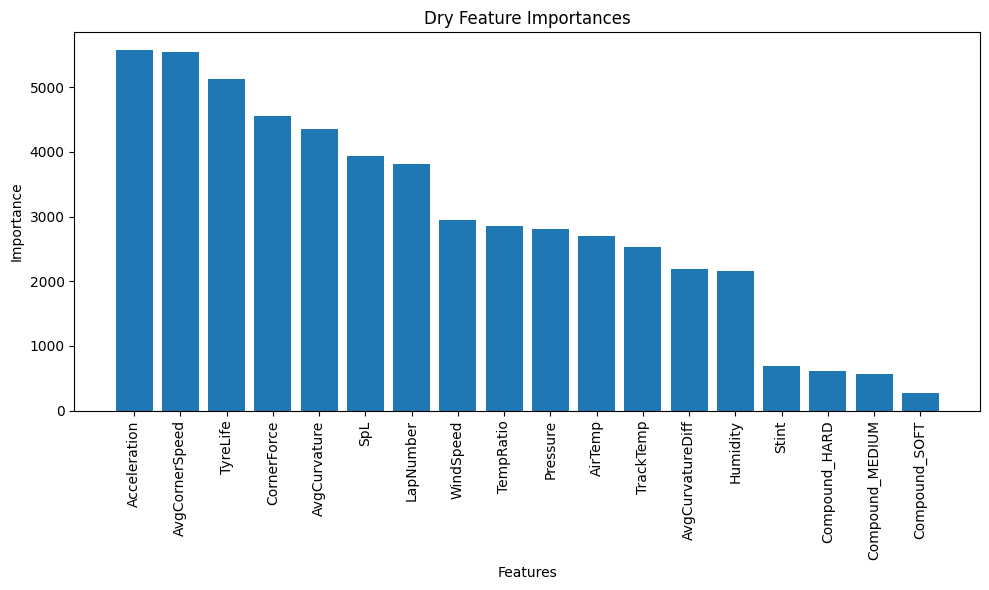

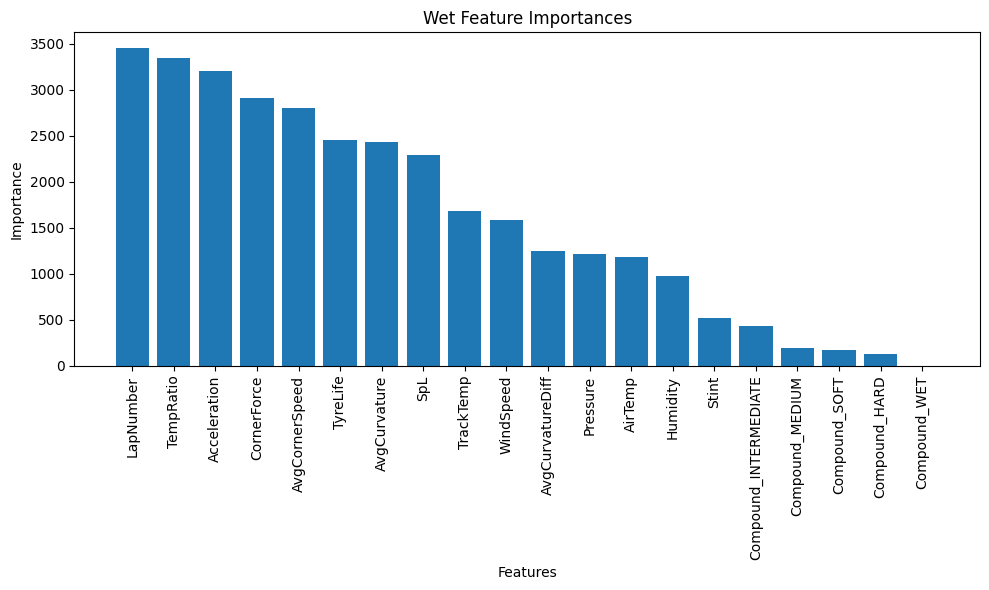

In [37]:
# Plot feature importances
def plot_feature_importances(model, title):
    feature_importances = model.named_steps['lgbm'].feature_importances_
    feature_names = model.named_steps['lgbm'].feature_name_
    indices = np.argsort(feature_importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.bar(range(len(feature_importances)), feature_importances[indices], align='center')
    plt.xticks(range(len(feature_importances)), np.array(feature_names)[indices], rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()
plot_feature_importances(pipeline_dry, "Dry Feature Importances")
plot_feature_importances(pipeline_wet, "Wet Feature Importances")